In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

Модели: Linear Regression, Scikit-learn GB, Random Forest

Пайплайн такой: текстовые фичи энкодим CountVectorizer'ом, категориальные - OneHot, числовые заскейлим Standart Scaler'ом

In [2]:
import pandas

In [3]:
x = pandas.read_excel('../data/train.xlsx', index_col=0)
test = pandas.read_excel('../data/test.xlsx', index_col=0)
x, y = x.drop(columns=['mean_price']), x['mean_price'] 

In [4]:
categorical_columns = ['предмет', 'tutor_rating', 'status']
numerical_columns = ['tutor_reviews', 'experience']
columns_to_drop = ['Education_2', 
                   'Desc_Education_2', 
                   'Education_3', 
                   'Desc_Education_3', 
                   'Education_4', 
                   'Desc_Education_4', 
                   'Ученая степень 1', 
                   'Ученое звание 1',
                   'Desc_Education_5',
                   'Desc_Education_6',
                   'Education_5',
                   'Education_6',
                   'Ученая степень 2',
                   'Ученое звание 2',
                   'ФИО']
text_columns = ['tutor_head_tags', 'categories', 'description', 'experience_desc']

In [5]:
def transform(df):
    df = df.drop(columns=columns_to_drop)
    df['description'].fillna('', inplace=True)
    df['experience_desc'].fillna('            Репетитор не предоставил информацию об опыте работы  ', inplace=True)
    df['status'].fillna(df['status'].value_counts().idxmax(), inplace=True)
    df['tutor_rating'].fillna(df['tutor_rating'].median(), inplace=True)
    df['Desc_Education_1'].fillna('', inplace=True)
    df['tutor_rating'] = df['tutor_rating'].apply(int)
    df['experience'] = df['experience'].fillna('0')
    df['experience'] = df['experience'].apply(lambda x: int(x.split()[0]))
    df[categorical_columns] = df[categorical_columns].astype("category")
    return df

In [6]:
x = transform(x)
test = transform(test)

# Обучаем

In [7]:
X_train, X_val, y_train, y_val = train_test_split(x, y, random_state=42, test_size=0.1)

In [8]:
ct = ColumnTransformer([(f"{col}_text_preprocess", CountVectorizer(), col) for col in text_columns] +
                       [("categorical_preprocess", OneHotEncoder(handle_unknown='infrequent_if_exist'), categorical_columns),
                        ("numerical_columns", StandardScaler(), numerical_columns)])

## Linear Regression

In [9]:
pipe = Pipeline(steps=[("transformer", ct), ("regressor", LinearRegression())])
pipe.fit(X_train, y_train)
print('LinReg Validation MSE:', mean_squared_error(y_val, pipe.predict(X_val)))
submit = pandas.read_csv('../data/sample_submit.csv', index_col=0)
submit['mean_price'] = pipe.predict(test)
submit.to_csv(f'LR.csv')

LinReg Validation MSE: 476.7489689870978


## Random Forest

In [10]:
pipe = Pipeline(steps=[("transformer", ct), ("regressor", RandomForestRegressor())])

In [11]:
param_grid = {
    "regressor__n_estimators": [i for i in range(100,1000+1, 100)],
    "regressor__min_samples_split": [i for i in range(2,6)],
}

In [12]:
from joblib import parallel_backend

In [13]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1,  verbose=10, refit=True)
with parallel_backend('multiprocessing'):
    search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print('RF Validation MSE:', mean_squared_error(y_val, search.predict(X_val)))
submit = pandas.read_csv('../data/sample_submit.csv', index_col=0)
submit['mean_price'] = search.predict(test)
submit.to_csv(f'RF.csv')

[CV 1/5; 1/40] START regressor__min_samples_split=2, regressor__n_estimators=100
[CV 2/5; 1/40] START regressor__min_samples_split=2, regressor__n_estimators=100
[CV 3/5; 1/40] START regressor__min_samples_split=2, regressor__n_estimators=100
[CV 4/5; 1/40] START regressor__min_samples_split=2, regressor__n_estimators=100
[CV 5/5; 1/40] START regressor__min_samples_split=2, regressor__n_estimators=100
[CV 1/5; 2/40] START regressor__min_samples_split=2, regressor__n_estimators=200
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 2/5; 2/40] START regressor__min_samples_split=2, regressor__n_estimators=200[CV 3/5; 2/40] START regressor__min_samples_split=2, regressor__n_estimators=200

[CV 2/5; 1/40] END regressor__min_samples_split=2, regressor__n_estimators=100;, score=0.190 total time= 2.2min
[CV 4/5; 2/40] START regressor__min_samples_split=2, regressor__n_estimators=200
[CV 5/5; 1/40] END regressor__min_samples_split=2, regressor__n_estimators=100;, score=0.234 tota

## Gradient Boosting

In [14]:
import numpy as np

In [15]:
pipe = Pipeline(steps=[("transformer", ct), ("regressor", GradientBoostingRegressor())])
param_grid = {
    "regressor__n_estimators": [i for i in range(100,1000+1, 100)],
    "regressor__learning_rate": np.arange(1e-4, 1e-2, 5e-4),
    "regressor__min_samples_split": [i for i in range(2,6)],
}

In [16]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1,  verbose=10, refit=True)
with parallel_backend('multiprocessing'):
    search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print('GB Validation MSE:', mean_squared_error(y_val, search.predict(X_val)))


[CV 1/5; 1/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=100
[CV 2/5; 1/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=100
[CV 3/5; 1/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=100
[CV 4/5; 1/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=100
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 5/5; 1/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=100
[CV 1/5; 2/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=200
[CV 2/5; 2/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=200
[CV 3/5; 2/800] START regressor__learning_rate=0.0001, regressor__min_samples_split=2, regressor__n_estimators=200
[CV 2/5; 1/800] 

In [17]:
submit = pandas.read_csv('../data/sample_submit.csv', index_col=0)
submit['mean_price'] = search.predict(test)
submit.to_csv(f'GB.csv')

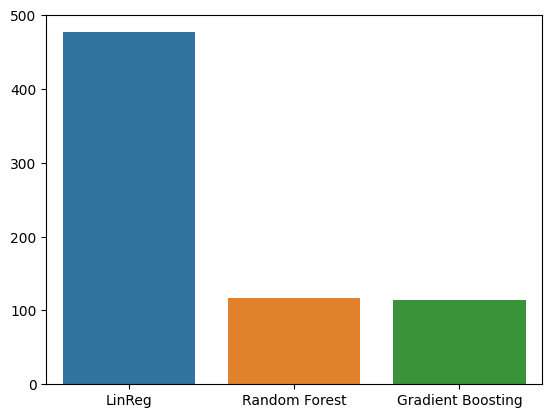

In [23]:
import seaborn as sns
ax = sns.barplot(y = [476.74, 116.92, 114.76], x = ['LinReg', 'Random Forest', 'Gradient Boosting'])

По результатам на отложенной выборке будем использовать градиентный бустинг